In [1]:
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
import statistics as stats
from scipy.stats import ttest_ind
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

### Data Exploration and Understanding

In [2]:
# Loading in the dataset
df = pd.read_csv("brca_data_w_subtypes.csv")
print(df.info())
print()
print(df.head())
print()
print(df.describe())
print()
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 705 entries, 0 to 704
Columns: 1941 entries, rs_CLEC3A to histological.type
dtypes: float64(827), int64(1110), object(4)
memory usage: 10.4+ MB
None

   rs_CLEC3A    rs_CPB1  rs_SCGB2A2  rs_SCGB1D2    rs_TFF1   rs_MUCL1  \
0   0.892818   6.580103   14.123672   10.606501  13.189237   6.649466   
1   0.000000   3.691311   17.116090   15.517231   9.867616   9.691667   
2   3.748150   4.375255    9.658123    5.326983  12.109539  11.644307   
3   0.000000  18.235519   18.535480   14.533584  14.078992   8.913760   
4   0.000000   4.583724   15.711865   12.804521   8.881669   8.430028   

    rs_GSTM1     rs_PIP  rs_ADIPOQ   rs_ADH1B  ...  pp_p62.LCK.ligand  \
0  10.520335  10.338490  10.248379  10.229970  ...          -0.691766   
1   8.179522   7.911723   1.289598   1.818891  ...           0.279067   
2  10.517330   5.114925  11.975349  11.911437  ...           0.219910   
3  10.557465  13.304434   8.205059   9.211476  ...          -0.266554

### Getting specifics about the Multi-omics dataset and other correlations

In [3]:
print("Multi-omics variables in the dataset.")
print("Number of RNAseq expression variables:", len([match for match in df.columns if match.startswith("rs")]))
print("Number of Copy Number Variables:", len([match for match in df.columns if match.startswith("cn")]))
print("Number of Protein Levels Variables:", len([match for match in df.columns if match.startswith("pp")]))
print("Number of Somatic Mutations in data:", len([match for match in df.columns if match.startswith("mu")]))

print()
print("There are 5 outcomes for the omics data above")
print("Vital Status:", df["vital.status"].unique())
print("Progesterone Receptors: ", (df["PR.Status"]).unique())
print("Estrogen Receptors: ", (df["ER.Status"]).unique())
print("HER2 Status", (df["HER2.Final.Status"]).unique())
print("Histological Cancer Subtype", (df["histological.type"]).unique())

Multi-omics variables in the dataset.
Number of RNAseq expression variables: 604
Number of Copy Number Variables: 860
Number of Protein Levels Variables: 223
Number of Somatic Mutations in data: 249

There are 5 outcomes for the omics data above
Vital Status: [0 1]
Progesterone Receptors:  ['Positive' 'Negative' nan 'Performed but Not Available' 'Indeterminate'
 'Not Performed']
Estrogen Receptors:  ['Positive' 'Negative' nan 'Performed but Not Available' 'Indeterminate'
 'Not Performed']
HER2 Status ['Negative' nan 'Positive' 'Equivocal' 'Not Available']
Histological Cancer Subtype ['infiltrating ductal carcinoma' 'infiltrating lobular carcinoma']


In [12]:
gene_suffix = ['rs_', 'cn_', 'mu_']
genes_all = []

for col in df.columns:
    for suffix in gene_suffix:
        if col.startswith(suffix):
            gene = col[len(suffix):]
            if all(suffix + gene in df.columns for suffix in gene_suffix):
                genes_all.append(gene)
unique_genes = set(genes_all)
print(f"The genes for which all forms of multi-omics data are present: {unique_genes}")

The genes for which all forms of multi-omics data are present: {'GPR98', 'FOXA1', 'MYH11', 'MUC16', 'FAT2', 'CNTNAP2', 'PEG3'}


In [13]:
gene_prefixes = ['rs_', 'cn_', 'pp_', 'mu_']
gene_columns = [col for col in df.columns if any(col.startswith(prefix) for prefix in gene_prefixes)]
unique_genes1 = set(col.split('_')[1] for col in gene_columns)
print(f"Number of unique genes in the dataset: {len(unique_genes1)}")

Number of unique genes in the dataset: 1631


### Analyzing data of a single gene and multiple genes multi-omics data to understand and predict effects on the outcomes

In [14]:
# Selecting genes here to analyze and use the first one for single gene omics analysis
df_muc16 = df[[val for val in df.columns if "MUC16" in val]]
print(df_muc16)

     rs_MUC16  cn_MUC16  mu_MUC16
0    2.715718         1         1
1    4.811800         0         0
2    6.842515        -1         0
3    4.535344        -1         0
4    4.676053         0         1
..        ...       ...       ...
700  2.054710         0         0
701  3.834195         0         0
702  3.323918         0         0
703  1.316783         0         0
704  7.617837         0         1

[705 rows x 3 columns]


In [15]:
omics_unique_genes = [col for col in df.columns if any(gene in col for gene in unique_genes)]
print(len(omics_unique_genes))

22


In [11]:
c=0
for gene_data in omics_unique_genes:
    print(f"T-Test on relationship between {gene_data} and patient survival")
    mean_alive = df.loc[df["vital.status"] == 0, gene_data].mean()
    mean_dead = df.loc[df["vital.status"] == 1, gene_data].mean()
    # print(f"Mean in Dead: {mean_dead}")
    # print(f"Mean in Alive: {mean_alive}")
    
    t_stat, p_val = ttest_ind(df.loc[df["vital.status"] == 0, gene_data],
                              df.loc[df["vital.status"] == 1, gene_data])
    if(p_val < 0.05):
        c+=1
    
    print(f'T-statistic: {t_stat}')
    print(f'P-value: {p_val}')
    print(f"")
    
print(f"Number of significant omics data of genes: {c}")

T-Test on relationship between rs_MUC16 and patient survival
T-statistic: -2.1354729424193644
P-value: 0.03306737441965191

T-Test on relationship between rs_CNTNAP2 and patient survival
T-statistic: 2.699933744804915
P-value: 0.0071021329740718715

T-Test on relationship between rs_GPR98 and patient survival
T-statistic: -1.7579877371890567
P-value: 0.07918474779417059

T-Test on relationship between rs_FOXA1 and patient survival
T-statistic: 0.8244993291490502
P-value: 0.4099355518391745

T-Test on relationship between rs_FAT2 and patient survival
T-statistic: -3.2309560776720154
P-value: 0.0012912649579201027

T-Test on relationship between rs_PEG3 and patient survival
T-statistic: -2.706877930325158
P-value: 0.006956801568734718

T-Test on relationship between rs_MYH11 and patient survival
T-statistic: -3.8327667389375693
P-value: 0.00013806225200052157

T-Test on relationship between cn_GPR98 and patient survival
T-statistic: 0.524308819159188
P-value: 0.6002290347586479

T-Test o

In [9]:
df_unique_genes = df[omics_unique_genes]
# df_unique_genes = df_unique_genes.drop('pp_MYH11', axis = 1)
print(df_unique_genes)

df_new = df.drop(['vital.status', 'PR.Status', 'ER.Status', 'HER2.Final.Status', 'histological.type'], axis = 1)
print()

     rs_MUC16  rs_CNTNAP2  rs_GPR98   rs_FOXA1   rs_FAT2    rs_PEG3  \
0    2.715718    9.885785  8.891220  12.696589  8.396041   8.197286   
1    4.811800    9.344277  7.883318  12.464073  9.128518   8.314152   
2    6.842515    8.652057  7.603679  12.638795  7.117963  12.233405   
3    4.535344   12.586292  8.171135  13.753339  5.684499   5.409554   
4    4.676053   10.732571  8.796819  13.444034  6.455607  11.649508   
..        ...         ...       ...        ...       ...        ...   
700  2.054710    0.926986  7.342820  12.633520  5.950426  10.771239   
701  3.834195    4.867086  8.013366  12.108079  5.290233   6.583645   
702  3.323918    5.484831  7.116687  12.696575  5.972904   6.639109   
703  1.316783    7.546005  5.313514  12.980322  4.121148   6.967745   
704  7.617837    3.169075  9.137739  12.965885  6.938951   5.119161   

      rs_MYH11  cn_GPR98  cn_FAT2  cn_CNTNAP2  ...  cn_MUC16  cn_PEG3  \
0    11.838799         0        0           1  ...         1        1   
1

In [10]:
random.seed(42)
# Try the Logistic Regression Model
scaler = StandardScaler()
X = df_unique_genes
X_scaled = scaler.fit_transform(X)
y = df['vital.status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

predictions_survival = log_reg.predict(X_test)
print(classification_report(y_test, predictions_survival))


              precision    recall  f1-score   support

           0       0.89      0.98      0.94       125
           1       0.33      0.06      0.11        16

    accuracy                           0.88       141
   macro avg       0.61      0.52      0.52       141
weighted avg       0.83      0.88      0.84       141



In [11]:
from sklearn.feature_selection import RFE

rfe = RFE(estimator=log_reg, n_features_to_select=10)  # Adjust n_features_to_select as needed
rfe = rfe.fit(X, y)

# Summarize the selection of the attributes
print("Num Features: %s" % (rfe.n_features_))
print("Selected Features: %s" % (X.columns[rfe.support_]))
print("Feature Ranking: %s" % (rfe.ranking_))

Num Features: 10
Selected Features: Index(['rs_FOXA1', 'rs_MYH11', 'cn_GPR98', 'cn_MYH11', 'cn_MUC16', 'mu_FAT2',
       'mu_GPR98', 'mu_FOXA1', 'mu_CNTNAP2', 'mu_PEG3'],
      dtype='object')
Feature Ranking: [ 8  7  2  1 10  5  1  1 11  4 13  1  1 12  9  1  1  6  1  1  1  3]


In [12]:
random.seed(42)
# Try the Gradient Boost Model
gradient_boost = GradientBoostingClassifier()
gradient_boost.fit(X_train, y_train)

predictions_survival = gradient_boost.predict(X_test)
print(classification_report(y_test, predictions_survival))


              precision    recall  f1-score   support

           0       0.89      0.97      0.93       125
           1       0.20      0.06      0.10        16

    accuracy                           0.87       141
   macro avg       0.54      0.52      0.51       141
weighted avg       0.81      0.87      0.83       141



In [13]:
rfe = RFE(estimator=gradient_boost, n_features_to_select=10)
rfe = rfe.fit(X, y)

# Summarize the selection of the attributes
print("Num Features: %s" % (rfe.n_features_))
print("Selected Features: %s" % (X.columns[rfe.support_]))
print("Feature Ranking: %s" % (rfe.ranking_))

Num Features: 10
Selected Features: Index(['rs_MUC16', 'rs_CNTNAP2', 'rs_GPR98', 'rs_FOXA1', 'rs_FAT2', 'rs_PEG3',
       'rs_MYH11', 'cn_PEG3', 'mu_GPR98', 'pp_MYH11'],
      dtype='object')
Feature Ranking: [ 1  1  1  1  1  1  1  9  3  4  6  2  8  1 13 11  1 12  7 10  5  1]


In [14]:
random.seed(42)
# Try the Neural Network Model on the omics_data
neural_network = MLPClassifier()
neural_network.fit(X_train, y_train)

predictions_survival = neural_network.predict(X_test)
print(classification_report(y_test, predictions_survival))

              precision    recall  f1-score   support

           0       0.89      0.97      0.93       125
           1       0.20      0.06      0.10        16

    accuracy                           0.87       141
   macro avg       0.54      0.52      0.51       141
weighted avg       0.81      0.87      0.83       141



c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [15]:
random.seed(42)
# Try the Naives Bayes Model on the omics_data
naive_bayes = GaussianNB()
naive_bayes.fit(X_train, y_train)

predictions_survival = naive_bayes.predict(X_test)
print(classification_report(y_test, predictions_survival))

              precision    recall  f1-score   support

           0       0.90      0.89      0.90       125
           1       0.22      0.25      0.24        16

    accuracy                           0.82       141
   macro avg       0.56      0.57      0.57       141
weighted avg       0.83      0.82      0.82       141



In [16]:
random.seed(42)
# Try the Random Forest Model on the omics_data
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

predictions_survival = clf.predict(X_test)
print(classification_report(y_test, predictions_survival))

              precision    recall  f1-score   support

           0       0.88      0.97      0.92       125
           1       0.00      0.00      0.00        16

    accuracy                           0.86       141
   macro avg       0.44      0.48      0.46       141
weighted avg       0.78      0.86      0.82       141



In [17]:
rfe = RFE(estimator=clf, n_features_to_select=10)
rfe = rfe.fit(X, y)

# Summarize the selection of the attributes
print("Num Features: %s" % (rfe.n_features_))
print("Selected Features: %s" % (X.columns[rfe.support_]))
print("Feature Ranking: %s" % (rfe.ranking_))

Num Features: 10
Selected Features: Index(['rs_MUC16', 'rs_CNTNAP2', 'rs_GPR98', 'rs_FOXA1', 'rs_FAT2', 'rs_PEG3',
       'rs_MYH11', 'cn_MYH11', 'cn_PEG3', 'pp_MYH11'],
      dtype='object')
Feature Ranking: [ 1  1  1  1  1  1  1  3  5  2  4  1  6  1  9 11  7 12  8 13 10  1]


In [18]:
random.seed(42)
# Try the Decision Tree Model on the omics_data
clf2 = DecisionTreeClassifier()
clf2.fit(X_train, y_train)

predictions_survival = clf2.predict(X_test)
print(classification_report(y_test, predictions_survival))

              precision    recall  f1-score   support

           0       0.89      0.91      0.90       125
           1       0.15      0.12      0.14        16

    accuracy                           0.82       141
   macro avg       0.52      0.52      0.52       141
weighted avg       0.81      0.82      0.81       141



In [19]:
random.seed(42)
# Try the SVM model on the omics_data
vector = svm.SVC()
vector.fit(X_train, y_train)

predictions_survival = vector.predict(X_test)
print(classification_report(y_test, predictions_survival))

              precision    recall  f1-score   support

           0       0.89      1.00      0.94       125
           1       0.00      0.00      0.00        16

    accuracy                           0.89       141
   macro avg       0.44      0.50      0.47       141
weighted avg       0.79      0.89      0.83       141



c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

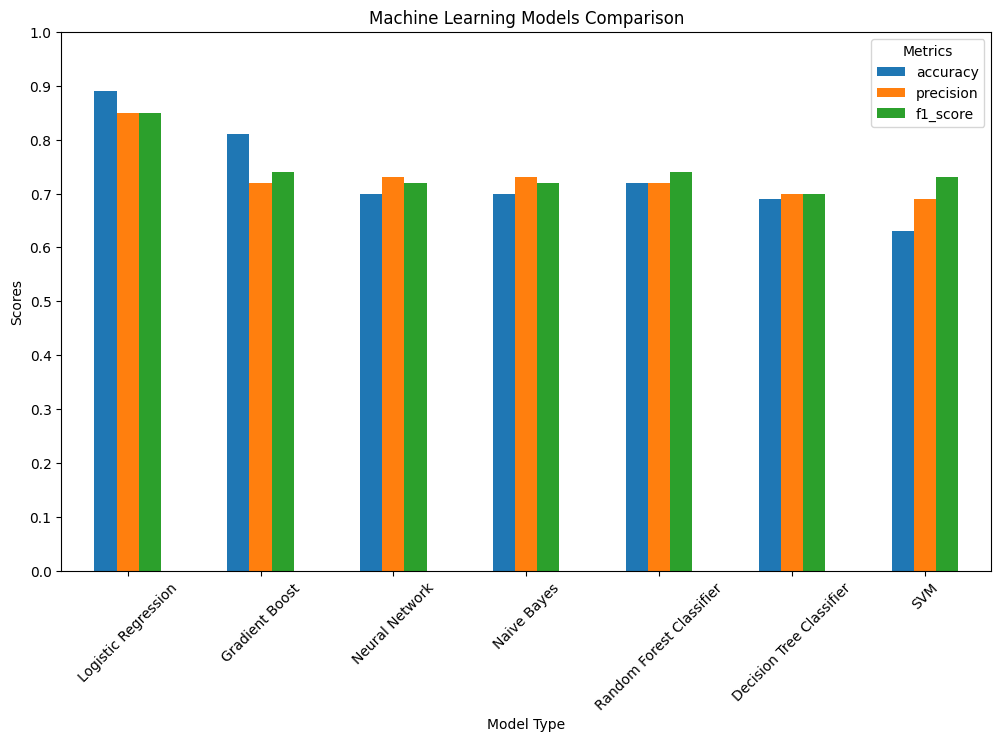

In [20]:
# Need to change values as per final models metrics

model_metrics = {
    'Logistic Regression': {'accuracy': 0.89, 'precision': 0.85, 'f1_score': 0.85},
    'Gradient Boost': {'accuracy': 0.81, 'precision': 0.72, 'f1_score': 0.74},
    'Neural Network': {'accuracy': 0.70, 'precision': 0.73, 'f1_score': 0.72},
    'Naive Bayes': {'accuracy': 0.70, 'precision': 0.73, 'f1_score': 0.72},
    'Random Forest Classifier': {'accuracy': 0.72, 'precision': 0.72, 'f1_score': 0.74},
    'Decision Tree Classifier': {'accuracy': 0.69, 'precision': 0.70, 'f1_score': 0.70},
    'SVM': {'accuracy': 0.63, 'precision': 0.69, 'f1_score': 0.73}
}

df_metrics = pd.DataFrame(model_metrics).T

# Plotting
df_metrics.plot(kind='bar', figsize=(12, 7))
plt.title('Machine Learning Models Comparison')
plt.ylabel('Scores')
plt.ylim(0,1)
plt.yticks([i * 0.1 for i in range(11)])
plt.xlabel('Model Type')
plt.xticks(rotation=45)
plt.legend(title='Metrics')
plt.show()

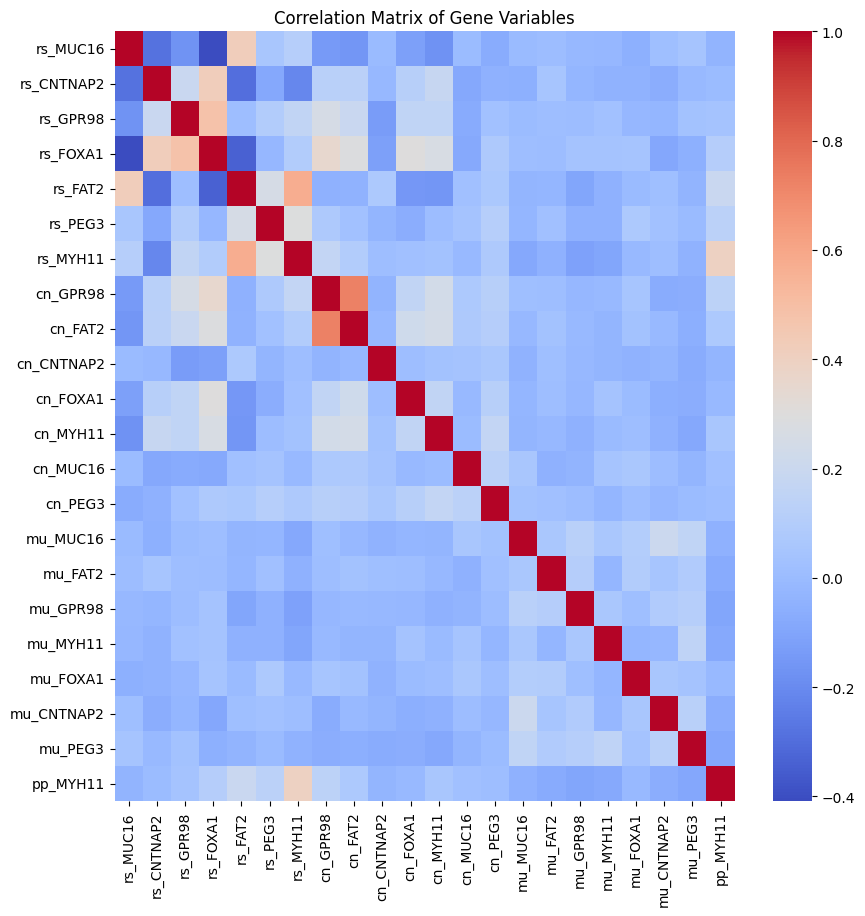

In [21]:
corr_matrix = df_unique_genes.corr()

plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title("Correlation Matrix of Gene Variables")
plt.show()

### Relation of Receptor Statuses and Cancer Histological type Statitcal tests and analysis

Chi-square test for PR.Status and histological type, p-value: 6.274956314187463e-09


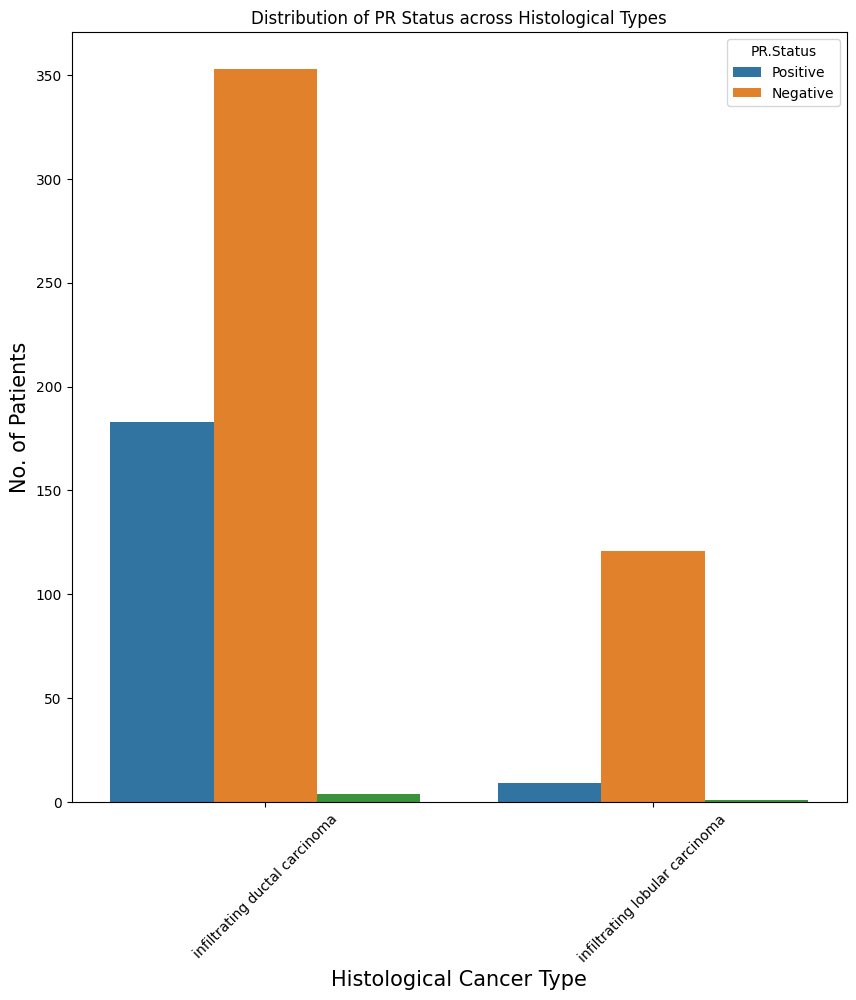

In [32]:
from scipy.stats import chi2_contingency
from sklearn.impute import SimpleImputer 

# Impute missing values for PR.Status, ER.Status, and HER2.Final.Status
imputer = SimpleImputer(strategy='most_frequent')
for col in ['PR.Status', 'ER.Status', 'HER2.Final.Status']:
    df[col] = imputer.fit_transform(df[[col]])
    if col != 'HER2.Final.Status':
        df[col] = df[col].replace({'Performed but Not Available': np.nan, 'Indeterminate': np.nan, 'Not Performed': np.nan})
        
histological_mapping = {0: 'infiltrating ductal carcinoma', 1: 'infiltrating lobular carcinoma'}

# Encode categorical variables
le = LabelEncoder()
df['histological.type'] = le.fit_transform(df['histological.type'].astype(str))
df['PR.Status'] = le.fit_transform(df['PR.Status'].astype(str))

# Map the encoded labels back to the original strings for plotting
df['histological.type'] = df['histological.type'].map(histological_mapping)
df = df.dropna()
contingency_table_pr_histology = pd.crosstab(df['histological.type'], df['PR.Status'])
chi2, p, dof, expected = chi2_contingency(contingency_table_pr_histology)
print(f'Chi-square test for PR.Status and histological type, p-value: {p}')

fig, ax = plt.subplots(figsize=(10, 10))
sns.countplot(x='histological.type', hue='PR.Status', data=df)
plt.title('Distribution of PR Status across Histological Types')
plt.xticks(rotation=45)
plt.xlabel("Histological Cancer Type", fontsize = 15)
plt.ylabel("No. of Patients", fontsize = 15)
plt.legend(title='PR.Status', labels=['Positive', 'Negative'])
plt.show()

Chi-square test for ER.Status and histological type, p-value: 2.8125967930730625e-08


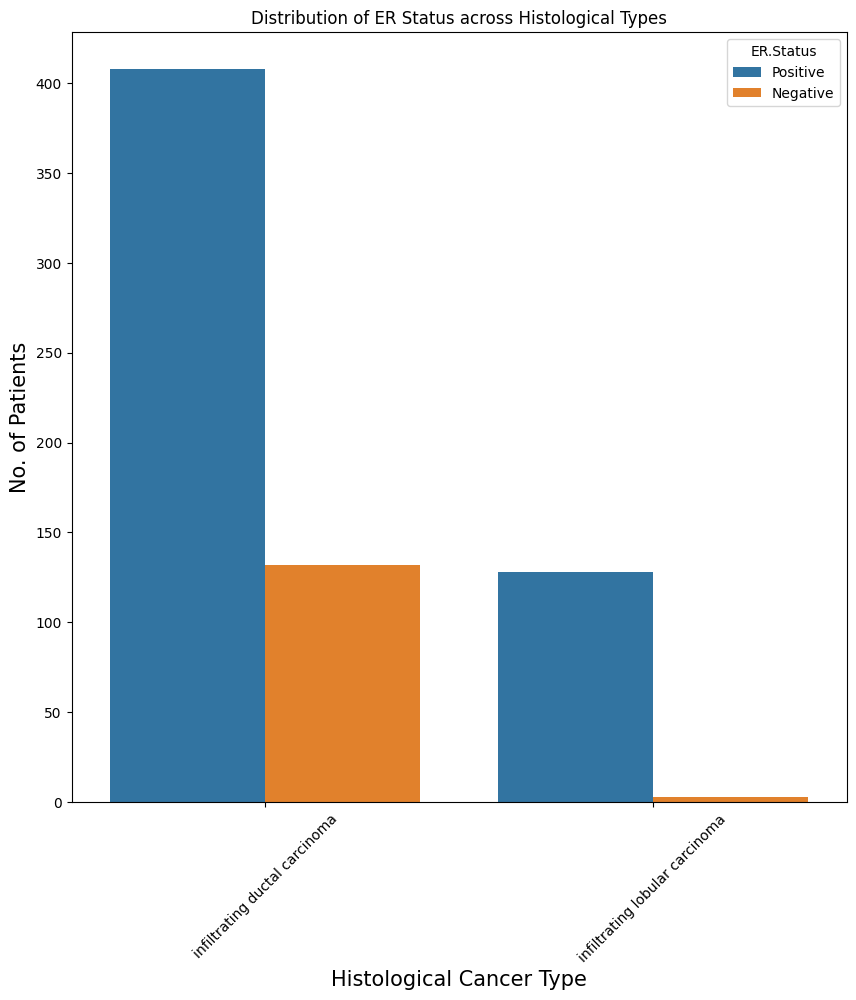

In [33]:
contingency_table_pr_histology = pd.crosstab(df['histological.type'], df['ER.Status'])
chi2, p, dof, expected = chi2_contingency(contingency_table_pr_histology)
print(f'Chi-square test for ER.Status and histological type, p-value: {p}')

fig, ax = plt.subplots(figsize=(10, 10))
sns.countplot(x='histological.type', hue='ER.Status', data=df)
plt.title('Distribution of ER Status across Histological Types')
plt.xticks(rotation=45)
plt.xlabel("Histological Cancer Type", fontsize = 15)
plt.ylabel("No. of Patients", fontsize = 15)
plt.legend(title='ER.Status', labels=['Positive', 'Negative'])
plt.show()

Chi-square test for HER2.Final.Status and histological type, p-value: 4.6685461114461214e-05


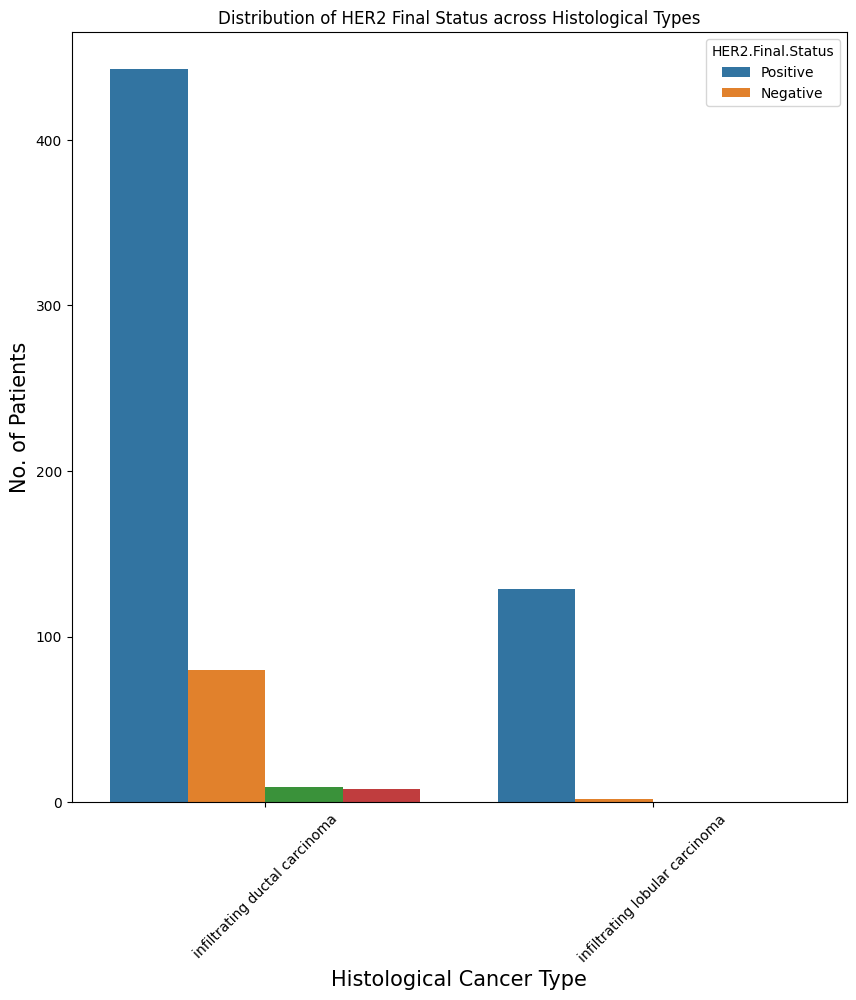

In [34]:
contingency_table_pr_histology = pd.crosstab(df['histological.type'], df['HER2.Final.Status'])
chi2, p, dof, expected = chi2_contingency(contingency_table_pr_histology)
print(f'Chi-square test for HER2.Final.Status and histological type, p-value: {p}')

fig, ax = plt.subplots(figsize=(10, 10))
sns.countplot(x='histological.type', hue='HER2.Final.Status', data=df)
plt.title('Distribution of HER2 Final Status across Histological Types')
plt.xticks(rotation=45)
plt.xlabel("Histological Cancer Type", fontsize = 15)
plt.ylabel("No. of Patients", fontsize = 15)
plt.legend(title='HER2.Final.Status', labels=['Positive', 'Negative'])
plt.show()

### Clustering

#### Imports

In [35]:
import snf
from snf import datasets
import pandas as pd
import numpy as np
from sklearn.cluster import spectral_clustering
from sklearn.metrics import v_measure_score
from snf import metrics
from snf import compute
from sklearn import cluster
import matplotlib.pyplot as plt

#### Def function(s)

In [36]:
def extract_column(file_name, column_index):
    """
    Extract a specific column from target CSV file.
    :param file_name: Path to the CSV file.
    :param column_index: Index of the column to extract (0-based).
    :return: List containing the values of the column.
    """
    column_data = []

    with open(file_name, 'r') as file:
        # Skip the header
        next(file)

        # Extract the column
        for line in file:
            row = line.strip().split(',')
            if len(row) > column_index:
                column_data.append(row[column_index])
            else:
                # Handle rows that are shorter than the column index
                column_data.append(None)

    return column_data

#### Extract output columns as test labels

In [37]:
file_name = 'brca_data_w_subtypes.csv' 

# Extract specific columns as list
histological_type = extract_column(file_name, -1)
vital_status_labels = np.array(extract_column(file_name, -5)).astype(int)
pr_status_labels = extract_column(file_name, -4)
er_status_labels = extract_column(file_name, -3)
her2_status_labels = extract_column(file_name, -2)

# Convert complex elements as binary number
histological_type_labels = np.array([0 if cancer == 'infiltrating ductal carcinoma' else 1 for cancer in histological_type])
print("Vital status:","\n",vital_status_labels,"\n")
print("PR status:","\n",pr_status_labels,"\n")
print("ER status:","\n",er_status_labels,"\n")
print("HER2 status:","\n",her2_status_labels,"\n")
print("Histological cancer type:","\n",histological_type,"\n")

Vital status: 
 [0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0
 0 0 0 1 1 1 0 1 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 0 0 1 1 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 

#### Read file and create dataframe

In [38]:
#Read file and remove head
df1 = pd.read_csv('brca_data_w_subtypes.csv', header=0)

#Check nan value
has_nan1 = df1.isnull().values.any()
print("Any NaN in DataFrame:", has_nan1)

#Fill 0 and check nan value again
df = df1.fillna(0)
has_nan = df.isnull().values.any()
print("Any NaN in DataFrame after Fill-0:", has_nan)

#Show data shape
data_array = df.to_numpy()
print("Data shape:", data_array.shape)

#Extract columns
def column_label_to_index(label):
    """Convert an Excel column label to zero-based column index."""
    index = 0
    for char in label:
        index = index * 26 + (ord(char.upper()) - ord('A')) + 1
    return index - 1

#Separate different omics
start_index_group1 = column_label_to_index('A')
end_index_group1 = column_label_to_index('WF') + 1 

start_index_group2 = column_label_to_index('WG')
end_index_group2 = column_label_to_index('BDH') + 1

start_index_group3 = column_label_to_index('BDI')
end_index_group3 = column_label_to_index('BMW') + 1

start_index_group4 = column_label_to_index('BMX')
end_index_group4 = column_label_to_index('BVL') + 1

group1 = df.iloc[:, start_index_group1:end_index_group1].to_numpy()
group2 = df.iloc[:, start_index_group2:end_index_group2].to_numpy().astype(np.float64)
group3 = df.iloc[:, start_index_group3:end_index_group3].to_numpy().astype(np.float64)
group4 = df.iloc[:, start_index_group4:end_index_group4].to_numpy()
groups = [group1, group2, group3, group4]

#Show shape of each group
for i, group in enumerate(groups):
    print(f"Shape of group {i+1}: {group.shape}")

Any NaN in DataFrame: True
Any NaN in DataFrame after Fill-0: False
Data shape: (705, 1941)
Shape of group 1: (705, 604)
Shape of group 2: (705, 860)
Shape of group 3: (705, 249)
Shape of group 4: (705, 223)


#### Implement SNF (Similarity Network Fusion)

In [39]:
#Make affinity networks and fuse them
affinity_networks = compute.make_affinity(groups, metric='euclidean', K=20, mu=0.5)
fused_network = snf.snf(affinity_networks, K=20)

#Compute and show best n-clusters option
best, second = snf.get_n_clusters(fused_network)
print(best, second)

#Create clusters and print cluster labels
fused_labels  = spectral_clustering(fused_network, n_clusters=4)
print(fused_labels)
labels = [vital_status_labels, fused_labels]


2 3


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


[3 3 0 0 3 2 2 2 2 0 0 3 3 2 3 3 3 3 0 0 3 0 1 2 1 2 3 0 3 3 1 3 3 0 0 3 3
 1 2 3 0 0 2 2 1 2 0 3 3 3 0 3 3 2 3 1 0 3 2 3 3 2 0 3 0 0 3 2 0 3 3 3 0 0
 0 0 2 3 2 2 1 3 2 1 3 3 3 0 0 2 3 0 3 2 3 2 2 0 3 3 2 0 3 3 3 0 2 2 0 0 3
 0 0 0 0 0 1 0 0 3 3 1 2 0 2 0 0 0 0 3 1 0 0 3 0 3 1 1 0 0 3 1 3 0 1 3 3 0
 3 0 0 1 1 0 0 0 0 1 3 3 1 3 3 3 2 0 3 3 3 3 0 3 3 3 3 3 1 3 3 3 0 2 0 0 0
 2 0 0 2 0 2 0 2 0 3 2 3 2 3 1 1 0 2 0 0 0 3 3 3 0 2 0 0 1 0 0 0 1 2 3 3 3
 3 0 1 3 0 3 2 0 0 2 2 3 0 1 3 2 3 0 2 0 0 1 0 3 2 0 2 1 0 2 0 0 2 2 3 3 3
 3 3 2 3 3 0 0 3 2 0 0 3 3 2 0 0 3 1 0 3 0 0 2 0 1 3 2 3 3 3 0 0 3 3 3 3 3
 3 3 2 1 0 0 2 1 0 2 0 0 3 3 3 2 2 3 0 2 3 3 3 2 0 3 3 3 2 3 0 3 3 3 3 3 1
 3 3 0 2 0 0 3 0 0 3 3 3 3 3 3 3 3 2 3 0 2 0 3 3 3 1 0 0 3 3 3 0 3 3 3 0 0
 0 1 2 3 3 3 2 0 3 0 3 0 3 3 0 2 0 2 1 0 3 3 1 0 1 3 2 1 0 2 3 3 3 0 3 0 3
 0 3 3 1 3 0 3 3 3 0 3 3 2 1 0 3 0 1 1 0 0 2 0 0 1 0 1 1 2 1 1 1 3 1 0 0 2
 1 0 0 0 3 3 1 1 0 0 3 1 1 0 2 3 0 0 1 0 2 2 3 3 2 1 1 1 3 0 0 0 1 1 3 0 0
 1 2 2 3 0 3 0 0 3 0 0 3 

#### Make clusters groups

In [40]:
# Create groups
c1 = []
c2 = []
c3 = []
c4 = []

#Fill groups with patients ID
for i in range(len(fused_labels)):
    if fused_labels[i] == 0:
        c1.append(i)
    elif fused_labels[i] == 1:
        c2.append(i)
    elif fused_labels[i] == 2:
        c3.append(i)
    else:
        c4.append(i)

#Show clusters with ID
print("Cluster 1:", len(c1), "patients", "\n", c1, "\n")
print("Cluster 2:", len(c2), "patients", "\n", c2, "\n")
print("Cluster 3:", len(c3), "patients", "\n", c3, "\n")
print("Cluster 4:", len(c4), "patients", "\n", c4, "\n")

#Store patients numbers of each cluster
cn = [len(c1),len(c2),len(c3),len(c4)]

Cluster 1: 234 patients 
 [2, 3, 9, 10, 18, 19, 21, 27, 33, 34, 40, 41, 46, 50, 56, 62, 64, 65, 68, 72, 73, 74, 75, 87, 88, 91, 97, 101, 105, 108, 109, 111, 112, 113, 114, 115, 117, 118, 123, 125, 126, 127, 128, 131, 132, 134, 138, 139, 143, 147, 149, 150, 153, 154, 155, 156, 165, 170, 180, 182, 183, 184, 186, 187, 189, 191, 193, 201, 203, 204, 205, 209, 211, 212, 214, 215, 216, 223, 226, 229, 230, 234, 239, 241, 242, 244, 247, 250, 252, 253, 264, 265, 268, 269, 273, 274, 277, 279, 280, 282, 289, 290, 300, 301, 304, 306, 307, 314, 320, 326, 335, 337, 338, 340, 341, 352, 354, 359, 360, 364, 368, 369, 370, 377, 379, 381, 384, 386, 389, 393, 398, 403, 405, 407, 412, 416, 421, 423, 426, 427, 429, 430, 432, 441, 442, 445, 446, 447, 452, 453, 457, 460, 461, 463, 473, 474, 475, 479, 480, 485, 487, 488, 490, 491, 493, 496, 502, 504, 505, 506, 507, 508, 509, 517, 519, 523, 525, 526, 528, 531, 534, 535, 536, 537, 544, 545, 549, 552, 553, 554, 560, 562, 563, 564, 573, 577, 584, 586, 590, 591, 595

#### Clustering result

In [41]:
# Counters
c1_v_1 = 0
c2_v_1 = 0
c3_v_1 = 0
c4_v_1 = 0

#Computing counters
for i in range(len(vital_status_labels)):
    if vital_status_labels[i] == 1:
        if i in c1:
            c1_v_1 += 1
        elif i in c2:
            c2_v_1 += 1
        elif i in c3:
            c3_v_1 += 1
        elif i in c4:
            c4_v_1 += 1
            
#Show survives in clusters
print("Cluster 1 survives:", c1_v_1, "\n")
print("Cluster 2 survives:", c2_v_1, "\n")
print("Cluster 3 survives:", c3_v_1, "\n")
print("Cluster 4 survives:", c4_v_1, "\n")

Cluster 1 survives: 37 

Cluster 2 survives: 11 

Cluster 3 survives: 14 

Cluster 4 survives: 32 



In [42]:
# Counters
c1_pr_1 = 0
c2_pr_1 = 0
c3_pr_1 = 0
c4_pr_1 = 0

#Computing counters
for i in range(len(pr_status_labels)):
    if pr_status_labels[i] == "Positive":
        if i in c1:
            c1_pr_1 += 1
        elif i in c2:
            c2_pr_1 += 1
        elif i in c3:
            c3_pr_1 += 1
        elif i in c4:
            c4_pr_1 += 1
            
#Show PR positive in clusters
print("Cluster 1 PR positive:", c1_pr_1, "\n")
print("Cluster 2 PR positive:", c2_pr_1, "\n")
print("Cluster 3 PR positive:", c3_pr_1, "\n")
print("Cluster 4 PR positive:", c4_pr_1, "\n")

Cluster 1 PR positive: 160 

Cluster 2 PR positive: 17 

Cluster 3 PR positive: 5 

Cluster 4 PR positive: 171 



In [43]:
# Counters
c1_er_1 = 0
c2_er_1 = 0
c3_er_1 = 0
c4_er_1 = 0

#Computing counters
for i in range(len(er_status_labels)):
    if er_status_labels[i] == "Positive":
        if i in c1:
            c1_er_1 += 1
        elif i in c2:
            c2_er_1 += 1
        elif i in c3:
            c3_er_1 += 1
        elif i in c4:
            c4_er_1 += 1
            
#Show ER positive in clusters
print("Cluster 1 ER positive:", c1_er_1, "\n")
print("Cluster 2 ER positive:", c2_er_1, "\n")
print("Cluster 3 ER positive:", c3_er_1, "\n")
print("Cluster 4 ER positive:", c4_er_1, "\n")

Cluster 1 ER positive: 191 

Cluster 2 ER positive: 28 

Cluster 3 ER positive: 10 

Cluster 4 ER positive: 185 



In [44]:
# Counters
c1_her2_1 = 0
c2_her2_1 = 0
c3_her2_1 = 0
c4_her2_1 = 0

#Computing counters
for i in range(len(her2_status_labels)):
    if her2_status_labels[i] == "Positive":
        if i in c1:
            c1_her2_1 += 1
        elif i in c2:
            c2_her2_1 += 1
        elif i in c3:
            c3_her2_1 += 1
        elif i in c4:
            c4_her2_1 += 1
            
#Show HRR2 positive in clusters
print("Cluster 1 HER2 positive:", c1_her2_1, "\n")
print("Cluster 2 HER2 positive:", c2_her2_1, "\n")
print("Cluster 3 HER2 positive:", c3_her2_1, "\n")
print("Cluster 4 HER2 positive:", c4_her2_1, "\n")

Cluster 1 HER2 positive: 29 

Cluster 2 HER2 positive: 43 

Cluster 3 HER2 positive: 2 

Cluster 4 HER2 positive: 12 



In [45]:
# Counters
c1_h_1 = 0
c2_h_1 = 0
c3_h_1 = 0
c4_h_1 = 0

#Computing counters
for i in range(len(histological_type_labels)):
    if histological_type_labels[i] == 0:
        if i in c1:
            c1_h_1 += 1
        elif i in c2:
            c2_h_1 += 1
        elif i in c3:
            c3_h_1 += 1
        elif i in c4:
            c4_h_1 += 1

#Show ductal carcinoma in clusters
print("Cluster 1 ductal carcinoma:", c1_h_1, "\n")
print("Cluster 2 ductal carcinoma:", c2_h_1, "\n")
print("Cluster 3 ductal carcinoma:", c3_h_1, "\n")
print("Cluster 4 ductal carcinoma:", c4_h_1, "\n")

Cluster 1 ductal carcinoma: 216 

Cluster 2 ductal carcinoma: 73 

Cluster 3 ductal carcinoma: 116 

Cluster 4 ductal carcinoma: 169 



In [46]:
# Counters
c1_h_2 = 0
c2_h_2 = 0
c3_h_2 = 0
c4_h_2 = 0

#Computing counters
for i in range(len(histological_type_labels)):
    if histological_type_labels[i] == 1:
        if i in c1:
            c1_h_2 += 1
        elif i in c2:
            c2_h_2 += 1
        elif i in c3:
            c3_h_2 += 1
        elif i in c4:
            c4_h_2 += 1
                   
#Show lobular carcinoma in clusters
print("Cluster 1 lobular carcinoma:", c1_h_2, "\n")
print("Cluster 2 lobular carcinoma:", c2_h_2, "\n")
print("Cluster 3 lobular carcinoma:", c3_h_2, "\n")
print("Cluster 4 lobular carcinoma:", c4_h_2, "\n")

Cluster 1 lobular carcinoma: 18 

Cluster 2 lobular carcinoma: 4 

Cluster 3 lobular carcinoma: 2 

Cluster 4 lobular carcinoma: 107 



#### Results visualization

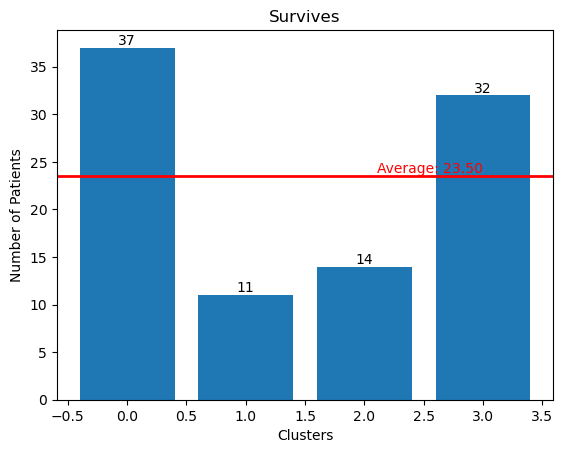

In [47]:
#Survives
vplot = [c1_v_1,c2_v_1,c3_v_1,c4_v_1]

vaverage = sum(vplot) / len(vplot)

plt.bar(range(len(vplot)), vplot)

for i, value in enumerate(vplot):
    plt.text(i, value, str(value), ha='center', va='bottom')

plt.axhline(y=vaverage, color='r', linestyle='-', linewidth=2)

plt.title("Survives")
plt.xlabel("Clusters")
plt.ylabel("Number of Patients")

plt.text(len(vplot)-1, vaverage, f'Average: {vaverage:.2f}', va='bottom', ha='right', color='red')

plt.show()


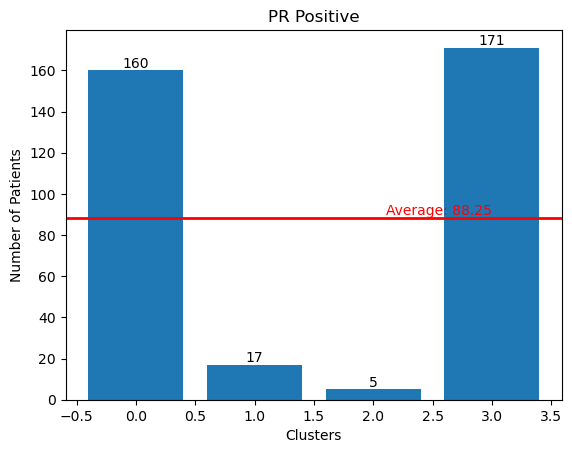

In [48]:
#PR
prplot = [c1_pr_1,c2_pr_1,c3_pr_1,c4_pr_1]

praverage = sum(prplot) / len(prplot)

plt.bar(range(len(prplot)), prplot)

for i, value in enumerate(prplot):
    plt.text(i, value, str(value), ha='center', va='bottom')

plt.axhline(y=praverage, color='r', linestyle='-', linewidth=2)

plt.title("PR Positive")
plt.xlabel("Clusters")
plt.ylabel("Number of Patients")

plt.text(len(prplot)-1, praverage, f'Average: {praverage:.2f}', va='bottom', ha='right', color='red')

plt.show()

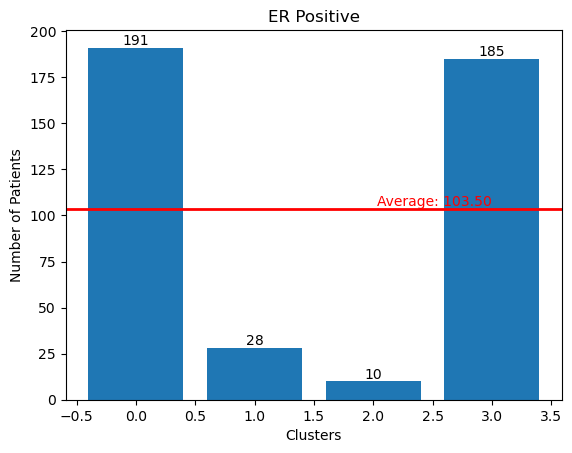

In [49]:
#ER
erplot = [c1_er_1,c2_er_1,c3_er_1,c4_er_1]

eraverage = sum(erplot) / len(erplot)

plt.bar(range(len(erplot)), erplot)

for i, value in enumerate(erplot):
    plt.text(i, value, str(value), ha='center', va='bottom')

plt.axhline(y=eraverage, color='r', linestyle='-', linewidth=2)

plt.title("ER Positive")
plt.xlabel("Clusters")
plt.ylabel("Number of Patients")

plt.text(len(erplot)-1, eraverage, f'Average: {eraverage:.2f}', va='bottom', ha='right', color='red')

plt.show()

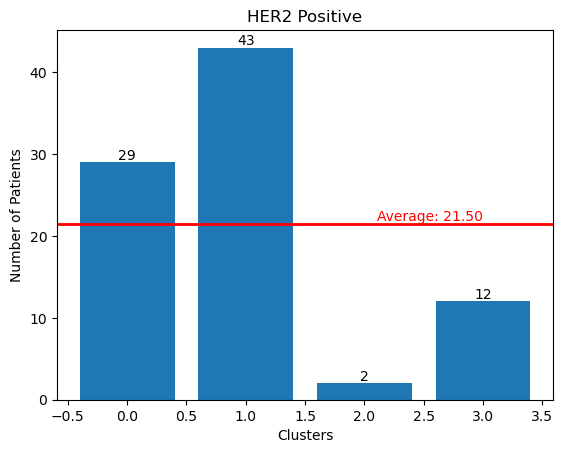

In [50]:
#HER2
her2plot = [c1_her2_1,c2_her2_1,c3_her2_1,c4_her2_1]

her2average = sum(her2plot) / len(her2plot)

plt.bar(range(len(her2plot)), her2plot)

for i, value in enumerate(her2plot):
    plt.text(i, value, str(value), ha='center', va='bottom')

plt.axhline(y=her2average, color='r', linestyle='-', linewidth=2)

plt.title("HER2 Positive")
plt.xlabel("Clusters")
plt.ylabel("Number of Patients")

plt.text(len(her2plot)-1, her2average, f'Average: {her2average:.2f}', va='bottom', ha='right', color='red')

plt.show()

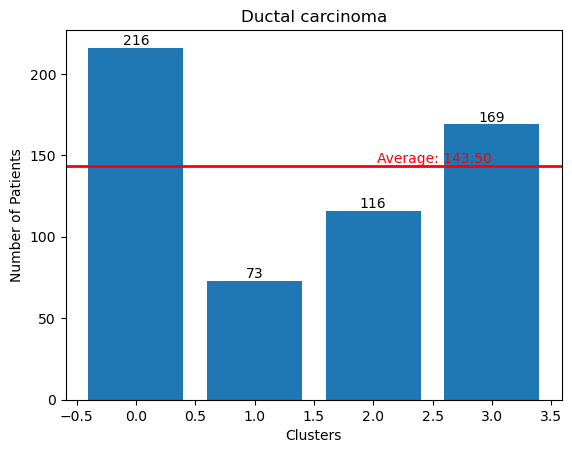

In [51]:
#Ductal carcinoma 
hplot = [c1_h_1,c2_h_1,c3_h_1,c4_h_1]

haverage = sum(hplot) / len(hplot)

plt.bar(range(len(hplot)), hplot)

for i, value in enumerate(hplot):
    plt.text(i, value, str(value), ha='center', va='bottom')

plt.axhline(y=haverage, color='r', linestyle='-', linewidth=2)

plt.title("Ductal carcinoma")
plt.xlabel("Clusters")
plt.ylabel("Number of Patients")

plt.text(len(hplot)-1, haverage, f'Average: {haverage:.2f}', va='bottom', ha='right', color='red')

plt.show()


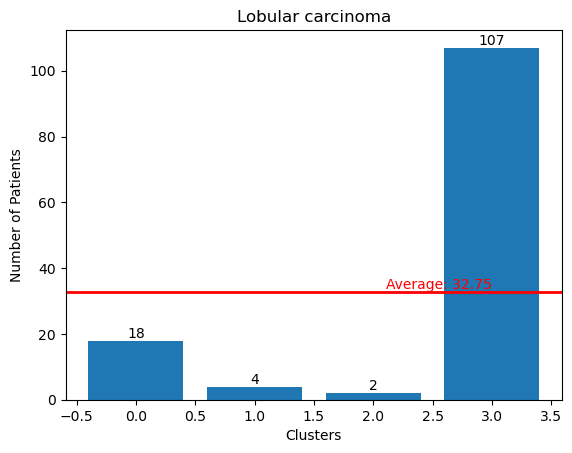

In [52]:
#Lobular carcinoma
h2plot = [c1_h_2,c2_h_2,c3_h_2,c4_h_2]

h2average = sum(h2plot) / len(h2plot)

plt.bar(range(len(h2plot)), h2plot)

for i, value in enumerate(h2plot):
    plt.text(i, value, str(value), ha='center', va='bottom')

plt.axhline(y=h2average, color='r', linestyle='-', linewidth=2)

plt.title("Lobular carcinoma")
plt.xlabel("Clusters")
plt.ylabel("Number of Patients")

plt.text(len(h2plot)-1, h2average, f'Average: {h2average:.2f}', va='bottom', ha='right', color='red')

plt.show()
